In [1]:
import pptk
from numpy.linalg import norm
import numpy as np
import pcl
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.spatial import ConvexHull
from matplotlib.path import Path
from sklearn.linear_model import RANSACRegressor

In [2]:
from sklearn.cluster import DBSCAN

In [3]:
def link(p1,p2, link_intensity):
    return np.linspace(p1, p2, num=int(norm(p1-p2)*link_intensity))

In [4]:
def convex_hull(pcl, intensity=150):
    
    hull = ConvexHull(pcl[:,:2])
    hull_path = Path( pcl[:,:2][hull.vertices] )
    results = np.vstack(hull_path.to_polygons())[:-1]
    n = results.shape[0]
    
    z_min, z_max = pcl[:,2].min(), pcl[:,2].max()
    down_points = np.hstack((results, z_min*np.ones(shape=(n,1))))
    up_points = np.hstack((results, z_max*np.ones(shape=(n,1))))
    
    box = np.zeros((0,3))

    for k in range(n):
        box = np.vstack((box, link(down_points[k%n], down_points[(k+1)%n], link_intensity=intensity)))
    for k in range(n):
        box = np.vstack((box, link(up_points[k%n], up_points[(k+1)%n], link_intensity=intensity)))
    for k in range(n):
        box = np.vstack((box, link(down_points[k%n], up_points[k%n], link_intensity=intensity)))
    
    return box

In [5]:
def load_from_bin(bin_path):
    obj = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    return obj[:,:3]

In [6]:
outer_radius = 50
inner_radius = 2.74

p = pcl.load("data_1/0000000011.pcd")
#coords = load_from_bin('data_3/0000000001.bin')#p.to_array()
coords = p.to_array()#load_from_bin('data_3/uu_000097.bin')#
coords = coords[(norm(coords[:,:2], axis=1)<=outer_radius)]
coords = coords[(norm(coords, axis=1)>inner_radius)]
x, y, z = coords[:,0], coords[:,1], coords[:,2]

In [7]:
ptf = coords[z<-1.3]

reg = RANSACRegressor()
reg.fit(ptf[:,:2],ptf[:,2])

preds = (reg.predict(ptf[:,:2])-ptf[:,2])
std_z = preds.std()
mean_z = reg.predict(ptf[:,:2]).mean()

In [8]:
%time
to_cluster = coords[z>mean_z+1.9*std_z]
clst = DBSCAN(eps=0.3)
clst.fit(to_cluster)

clst_labels = clst.labels_
labels, counts = np.unique(clst_labels, return_counts=True)

to_cluster = to_cluster[np.isin(clst_labels, labels[counts>2])]
clst_labels = clst_labels[np.isin(clst_labels, labels[counts>2])]

bhulls = np.vstack([convex_hull(to_cluster[clst_labels==k], intensity=50) for k in np.unique(clst_labels)[1:]])
to_cluster = np.vstack((to_cluster, bhulls))

bhull_color = int(np.quantile(np.unique(clst_labels)[1:], .50))
clst_labels = np.hstack((clst_labels, bhull_color*np.ones(bhulls.shape[0])))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


In [34]:
v = pptk.viewer(to_cluster, clst_labels)#, pptk.points(preds))
v.set(lookat=[0,0,0])
v.set(phi=np.pi, theta=np.pi/2, r=outer_radius)

In [37]:
bhulls_2d = bhulls[(-10<bhulls[:,1])&(bhulls[:,1]<10)]
#bhulls_2d = bhulls_2d[::25,:2]

(-51.7445426667463, 54.451543399168166, -10.99939971629429, 11.000065143172147)

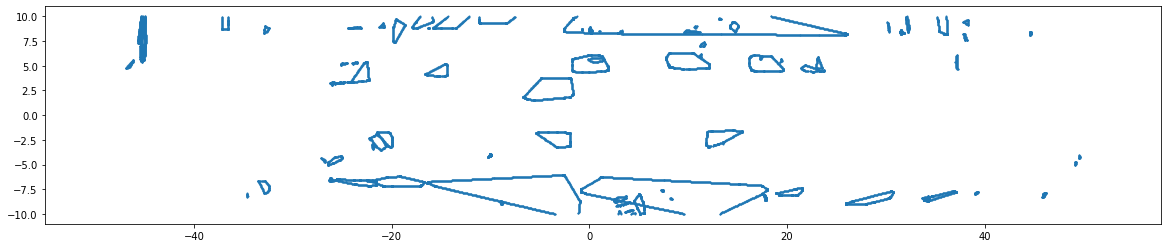

In [45]:
from pylab import rcParams

rcParams['figure.figsize'] = 20,4
plt.scatter(bhulls_2d[::5,0], bhulls_2d[::5,1], s=1)
plt.axis('equal')

In [70]:
np.save('obstacles.npy', bhulls_2d)